In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import xgcm
from xgcm.autogenerate import generate_grid_ds
from functools import partial
from scipy.signal import butter, filtfilt
from cmocean import cm

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py:137: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  RuntimeWarning,


In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
#cluster = PBSCluster(cores=28, processes=18, walltime='00:40:00')
#print(cluster.job_script())
#print(cluster.job_header)
w = cluster.scale(6)

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.1.86:53606 Dashboard: http://10.148.1.86:8787/status,Cluster Workers: 6 Cores: 168 Memory: 720.00 GB


_________
# 1. Read dataset


In [5]:
out_dir_work = '/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/'

grid = xr.open_dataset(out_dir_work+'Grid.nc', decode_coords=True)
ds_U = xr.open_zarr(out_dir_work+'U_total_rechunk.zarr')
ds_V = xr.open_zarr(out_dir_work+'V_total_rechunk.zarr')
ds_KPP = xr.open_zarr(out_dir_work+'KPPhbl_total_rechunk.zarr')

ds = xr.merge([ds_U,ds_V,ds_KPP,grid])
print(ds)

<xarray.Dataset>
Dimensions:  (depth: 52, lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 9415)
Coordinates:
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon_g    (lon_g) float64 -18.04 -18.02 -18.0 -17.98 ... -14.42 -14.4 -14.38
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * lat_g    (lat_g) float64 47.4 47.41 47.42 47.44 ... 49.94 49.96 49.97 49.98
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
    XC       (lat, lon) float32 ...
    YC       (lat, lon) float32 ...
    XG       (lat_g, lon_g) float32 ...
    YG       (lat_g, lon_g) float32 ...
    CS       (lat, lon) float32 ...
    SN       (lat, lon) float32 ...
    Depth    (lat, lon) float32 ...
    dxC      (lat, lon_g) float32 ...
    dyC      (lat_g, lon) float32 ...
    dxG      (lat_g, lon) float32 ...
    dyG      (lat, lon_g) float32 ...
    rA

In [6]:
gridx = xgcm.Grid(ds, coords={'X':{'center':'lon', 'left':'lon_g'},
                              'Y':{'center':'lat', 'left':'lat_g'}}, periodic=['X', 'Y'])
print(gridx)

<xgcm.Grid>
X Axis (periodic):
  * center   lon --> left
  * left     lon_g --> center
Y Axis (periodic):
  * center   lat --> left
  * left     lat_g --> center


In [7]:
def butter_filter(x, b, a):
    return xr.apply_ufunc(partial(filtfilt, b, a),
                          x.chunk(),
                          dask='parallelized',
                          output_dtypes=[x.dtype],
                          kwargs={'axis': 0})

________
# 1. Submesoscale band (1.3-5 days)

## 1.1 to compare differences between two low-pass filtered results and band-pass filtered results

In [9]:
lowcut = 1/120/3600
highcut = 1/30/3600

fs = 1/3600
nyq = 0.5*fs
low = lowcut/nyq
high = highcut/nyq

b, a = butter(4, low, 'low')
c, d = butter(4, high, 'low')
e, f = butter(4, [low, high], 'bandpass')

In [10]:
du_dx = gridx.diff(butter_filter(ds.U, b, a), 'X')/gridx.interp(ds.dxG, 'Y')
dv_dy = gridx.diff(butter_filter(ds.V, b, a), 'Y')/gridx.interp(ds.dyG, 'X')
du_dy = gridx.interp(gridx.interp(gridx.diff(butter_filter(ds.U, b, a), 'Y')/gridx.interp(ds.dyC, 'X'), 'X'), 'Y')
dv_dx = gridx.interp(gridx.interp(gridx.diff(butter_filter(ds.V, b, a), 'X')/gridx.interp(ds.dxC, 'Y'), 'X'), 'Y')

PI_1 = (gridx.interp(butter_filter(ds.U**2, b, a), 'X')-gridx.interp(butter_filter(ds.U, b, a)**2, 'X'))*du_dx
PI_2 = (gridx.interp(butter_filter(ds.V**2, b, a), 'Y')-gridx.interp(butter_filter(ds.V, b, a)**2, 'Y'))*dv_dy
PI_3 = (butter_filter(gridx.interp(ds.V,'Y')*gridx.interp(ds.U,'X'), b, a) -butter_filter(gridx.interp(ds.V,'Y'), b, a)*butter_filter(gridx.interp(ds.U,'X'), b, a) )*(du_dy+dv_dx)

PI_cg_120h = -(PI_1+PI_2+PI_3)
PI_cg_120h

<xarray.DataArray (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<neg, shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 199, 175), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36

In [11]:
du_dx = gridx.diff(butter_filter(ds.U, c, d), 'X')/gridx.interp(ds.dxG, 'Y')
dv_dy = gridx.diff(butter_filter(ds.V, c, d), 'Y')/gridx.interp(ds.dyG, 'X')
du_dy = gridx.interp(gridx.interp(gridx.diff(butter_filter(ds.U, c, d), 'Y')/gridx.interp(ds.dyC, 'X'), 'X'), 'Y')
dv_dx = gridx.interp(gridx.interp(gridx.diff(butter_filter(ds.V, c, d), 'X')/gridx.interp(ds.dxC, 'Y'), 'X'), 'Y')

PI_1 = (gridx.interp(butter_filter(ds.U**2, c, d), 'X')-gridx.interp(butter_filter(ds.U, c, d)**2, 'X'))*du_dx
PI_2 = (gridx.interp(butter_filter(ds.V**2, c, d), 'Y')-gridx.interp(butter_filter(ds.V, c, d)**2, 'Y'))*dv_dy
PI_3 = (butter_filter(gridx.interp(ds.V,'Y')*gridx.interp(ds.U,'X'), c, d) -butter_filter(gridx.interp(ds.V,'Y'), c, d)*butter_filter(gridx.interp(ds.U,'X'), c, d) )*(du_dy+dv_dx)

PI_cg_30h = -(PI_1+PI_2+PI_3)
PI_cg_30h

<xarray.DataArray (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<neg, shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 199, 175), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36

In [12]:
du_dx = gridx.diff(butter_filter(ds.U, e, f), 'X')/gridx.interp(ds.dxG, 'Y')
dv_dy = gridx.diff(butter_filter(ds.V, e, f), 'Y')/gridx.interp(ds.dyG, 'X')
du_dy = gridx.interp(gridx.interp(gridx.diff(butter_filter(ds.U, e, f), 'Y')/gridx.interp(ds.dyC, 'X'), 'X'), 'Y')
dv_dx = gridx.interp(gridx.interp(gridx.diff(butter_filter(ds.V, e, f), 'X')/gridx.interp(ds.dxC, 'Y'), 'X'), 'Y')

PI_1 = (gridx.interp(butter_filter(ds.U**2, e, f), 'X')-gridx.interp(butter_filter(ds.U, e, f)**2, 'X'))*du_dx
PI_2 = (gridx.interp(butter_filter(ds.V**2, e, f), 'Y')-gridx.interp(butter_filter(ds.V, e, f)**2, 'Y'))*dv_dy
PI_3 = (butter_filter(gridx.interp(ds.V,'Y')*gridx.interp(ds.U,'X'), e, f) -butter_filter(gridx.interp(ds.V,'Y'), e, f)*butter_filter(gridx.interp(ds.U,'X'), c, d) )*(du_dy+dv_dx)

PI_cg_30h_120h = (PI_1+PI_2+PI_3)
PI_cg_30h_120h

<xarray.DataArray (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<add, shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 199, 175), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36

In [17]:
out_dir_store = '/home1/scratch/xyu/OSMOSIS_llc4320/Pi_omega/'
depth_all = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51]

In [ ]:
# works better with few worker but a lot of memories
VV = ['PI_cg_120h']

for depth in depth_all:
    
    for vv in VV:
        
        PI_cg_120h_single = PI_cg_120h.isel(depth=depth)
        chunks = {'lat': 201, 'lon': 177, 'time':9415}            
        PI_cg_120h_single = PI_cg_120h_single.chunk(chunks)
        PI_cg_120h_single = np.real(PI_cg_120h_single).rename('PI_cg_120h_single')     
        PI_cg_120h_single = PI_cg_120h_single.to_dataset()
        file_out = out_dir_store+'/%s_d%02d.zarr'%(vv,depth)
        PI_cg_120h_single.to_zarr(file_out, mode='w')                    
        print('depth=%d - allready processed'%(depth))

In [ ]:
# works better with few worker but a lot of memories
VV = ['PI_cg_30h']

for depth in depth_all:
    
    for vv in VV:
        
        PI_cg_30h_single = PI_cg_30h.isel(depth=depth)
        chunks = {'lat': 201, 'lon': 177, 'time':9415}            
        PI_cg_30h_single = PI_cg_30h_single.chunk(chunks)
        PI_cg_30h_single = np.real(PI_cg_30h_single).rename('PI_cg_30h_single')     
        PI_cg_30h_single = PI_cg_30h_single.to_dataset()
        file_out = out_dir_store+'/%s_d%02d.zarr'%(vv,depth)
        PI_cg_30h_single.to_zarr(file_out, mode='w')                    
        print('depth=%d - allready processed'%(depth))

In [ ]:
# works better with few worker but a lot of memories
VV = ['PI_cg_30h_120h']

for depth in depth_all:
    
    for vv in VV:
        
        PI_cg_30h_120h_single = PI_cg_30h_120h.isel(depth=depth)
        chunks = {'lat': 201, 'lon': 177, 'time':9415}            
        PI_cg_30h_120h_single = PI_cg_30h_120h_single.chunk(chunks)
        PI_cg_30h_120h_single = np.real(PI_cg_30h_120h_single).rename('PI_cg_30h_120h_single')     
        PI_cg_30h_120h_single = PI_cg_30h_120h_single.to_dataset()
        file_out = out_dir_store+'/%s_d%02d.zarr'%(vv,depth)
        PI_cg_30h_120h_single.to_zarr(file_out, mode='w')                    
        print('depth=%d - allready processed'%(depth))

## 1.2 Read results

In [5]:
out_dir_store = '/home1/scratch/xyu/OSMOSIS_llc4320/Pi_omega/'
D = [xr.open_zarr(out_dir_store+'PI_cg_120h_d%02d.zarr'%(depth)) for depth in range(52)]

PI_cg_120h = xr.concat(D, dim='depth')
PI_cg_120h = PI_cg_120h.PI_cg_120h_single
PI_cg_120h

<xarray.DataArray 'PI_cg_120h_single' (depth: 52, time: 9415, lat: 201, lon: 177)>
dask.array<concatenate, shape=(52, 9415, 201, 177), dtype=float32, chunksize=(1, 9415, 201, 177), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3

In [6]:
out_dir_store = '/home1/scratch/xyu/OSMOSIS_llc4320/Pi_omega/'
D = [xr.open_zarr(out_dir_store+'PI_cg_30h_d%02d.zarr'%(depth)) for depth in range(52)]

PI_cg_30h = xr.concat(D, dim='depth')
PI_cg_30h = PI_cg_30h.PI_cg_30h_single
PI_cg_30h

<xarray.DataArray 'PI_cg_30h_single' (depth: 52, time: 9415, lat: 201, lon: 177)>
dask.array<concatenate, shape=(52, 9415, 201, 177), dtype=float32, chunksize=(1, 9415, 201, 177), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3

In [7]:
out_dir_store = '/home1/scratch/xyu/OSMOSIS_llc4320/Pi_omega/'
D = [xr.open_zarr(out_dir_store+'PI_cg_30h_120h_d%02d.zarr'%(depth)) for depth in range(52)]

PI_cg_30h_120h = xr.concat(D, dim='depth')
PI_cg_30h_120h = PI_cg_30h_120h.PI_cg_30h_120h_single
PI_cg_30h_120h

<xarray.DataArray 'PI_cg_30h_120h_single' (depth: 52, time: 9415, lat: 201, lon: 177)>
dask.array<concatenate, shape=(52, 9415, 201, 177), dtype=float32, chunksize=(1, 9415, 201, 177), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3

In [8]:
#out_dir_work = '/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/'
#grid = xr.open_dataset(out_dir_work+'Grid.nc', decode_coords=True)
#ds_PI = xr.merge([PI_cg_120h,PI_cg_30h,grid,ds_U])
ds_PI = xr.merge([PI_cg_120h,PI_cg_30h,PI_cg_30h_120h])
ds_PI

<xarray.Dataset>
Dimensions:                (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
  * time                   (time) float64 0.0 0.04167 0.08333 ... 392.2 392.2
  * lat                    (lat) float64 47.4 47.42 47.43 ... 49.96 49.98 49.99
  * lon                    (lon) float64 -18.03 -18.01 -17.99 ... -14.39 -14.36
  * depth                  (depth) float64 0.5 1.57 2.79 ... 900.1 945.6 992.3
Data variables:
    PI_cg_120h_single      (depth, time, lat, lon) float32 dask.array<chunksize=(1, 9415, 201, 177), meta=np.ndarray>
    PI_cg_30h_single       (depth, time, lat, lon) float32 dask.array<chunksize=(1, 9415, 201, 177), meta=np.ndarray>
    PI_cg_30h_120h_single  (depth, time, lat, lon) float32 dask.array<chunksize=(1, 9415, 201, 177), meta=np.ndarray>

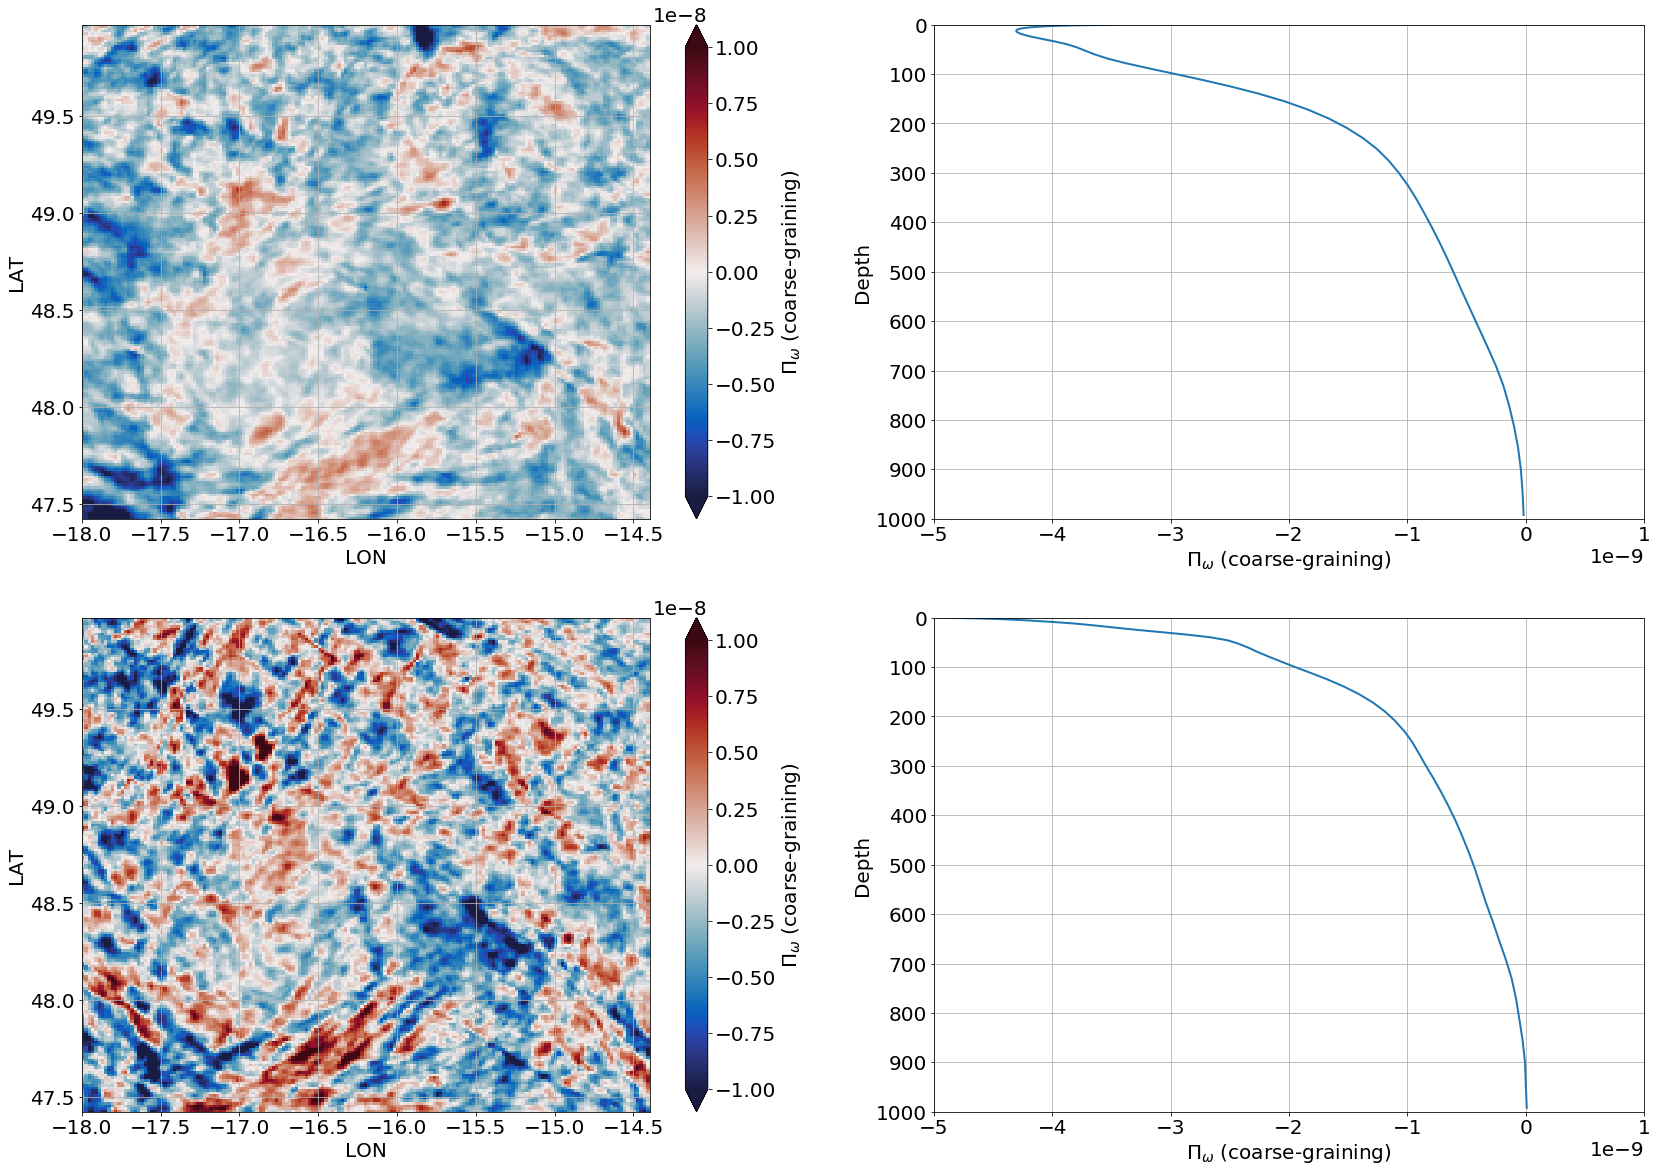

In [29]:
plt.rc('font', size=20) 

font_size=20

fig, ax = plt.subplots(figsize=(28,20))
ax = plt.subplot(221)
cax = (ds_PI.PI_cg_120h_single-ds_PI.PI_cg_30h_single).isel(lat=slice(2,-2),lon=slice(2,-2),depth=slice(10,50)).mean(['depth','time']).plot(x='lon', y='lat',cmap=cm.balance, vmin=-1e-8,vmax=1e-8, add_colorbar = False)
ax.grid()
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('$\Pi_{\omega}$ (coarse-graining)', fontsize=font_size)
ax.set_ylabel('LAT',fontsize=font_size)
ax.set_xlabel('LON',fontsize=font_size)
ax.tick_params(labelsize=font_size)

ax = plt.subplot(222)
(ds_PI.PI_cg_120h_single-ds_PI.PI_cg_30h_single).isel(lat=slice(2,-2),lon=slice(2,-2),time=slice(10,-10)).mean(['time','lat','lon']).plot(y='depth', yincrease=False, linewidth=2)
ax.grid()
ax.set_xlim([-5e-9,1e-9])
ax.set_ylim([1000., 0.])
ax.set_xticks([-5e-9, -4e-9,-3e-9, -2e-9, -1e-9, 0., 1e-9])
ax.set_ylabel('Depth',fontsize=font_size)
ax.set_xlabel('$\Pi_{\omega}$ (coarse-graining)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_yticks([1000., 900,800,700,600,500,400,300,200,100,0.])

ax = plt.subplot(223)
cax = (ds_PI.PI_cg_30h_120h_single).isel(lat=slice(2,-2),lon=slice(2,-2),depth=slice(10,50)).mean(['depth','time']).plot(x='lon', y='lat',cmap=cm.balance, vmin=-1e-8,vmax=1e-8, add_colorbar = False)
ax.grid()
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('$\Pi_{\omega}$ (coarse-graining)', fontsize=font_size)
ax.set_ylabel('LAT',fontsize=font_size)
ax.set_xlabel('LON',fontsize=font_size)
ax.tick_params(labelsize=font_size)

ax = plt.subplot(224)
(ds_PI.PI_cg_30h_120h_single).isel(lat=slice(2,-2),lon=slice(2,-2),time=slice(10,-10)).mean(['time','lat','lon']).plot(y='depth', yincrease=False, linewidth=2)
ax.grid()
ax.set_xlim([-5e-9,1e-9])
ax.set_ylim([1000., 0.])
ax.set_xticks([-5e-9, -4e-9,-3e-9, -2e-9, -1e-9, 0., 1e-9])
ax.set_ylabel('Depth',fontsize=font_size)
ax.set_xlabel('$\Pi_{\omega}$ (coarse-graining)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_yticks([1000., 900,800,700,600,500,400,300,200,100,0.])

#plt.savefig('/home1/datawork/xyu/OSMOSIS_llc4320/Figures/Pi_omega_together1_coarse_graining.png')

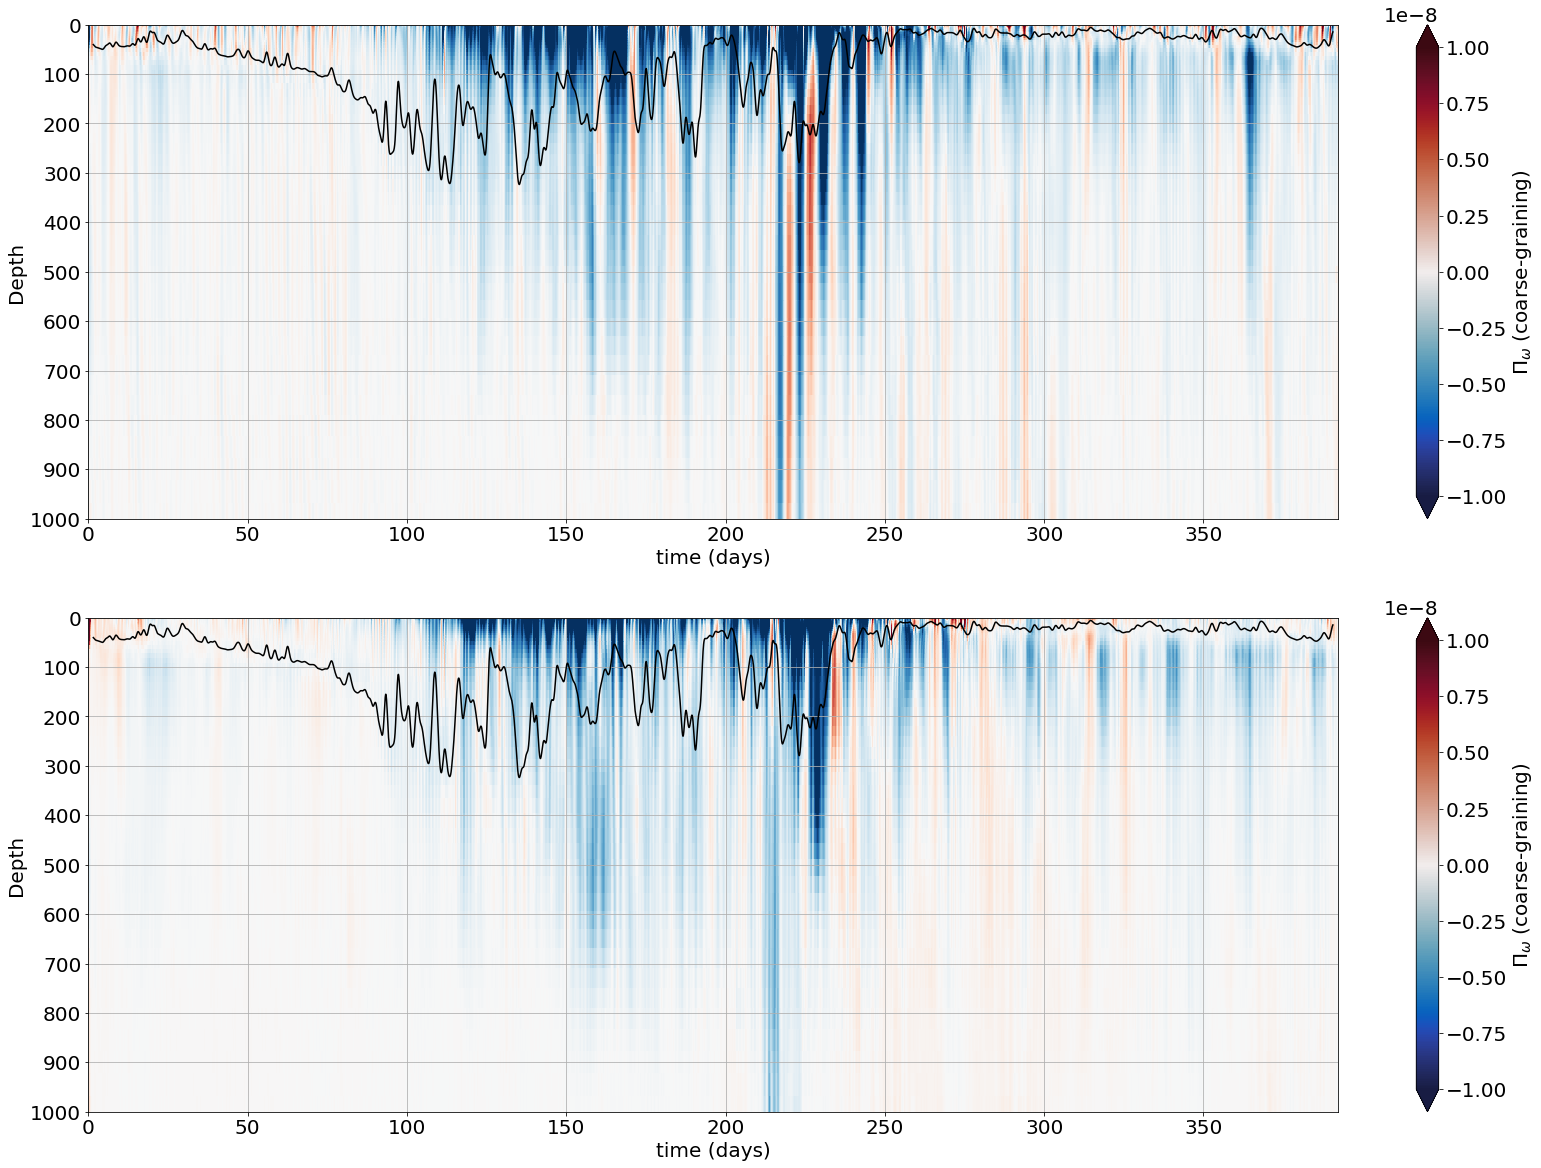

In [32]:
plt.rc('font', size=20) 
font_size=20
fig, ax = plt.subplots(figsize=(28,20))

ax = plt.subplot(211)
cax = (ds_PI.PI_cg_120h_single-ds_PI.PI_cg_30h_single).isel(lat=slice(1,-1),lon=slice(1,-1)).mean(['lon','lat']).plot(x='time', y='depth',cmap='RdBu_r', vmin=-1e-8,vmax=1e-8,yincrease=False, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('$\Pi_{\omega}$ (coarse-graining)', fontsize=font_size)
ax.grid()
ax.set_ylim([1000., 0.])
ds_MLD.mld_filter.mean(['lat','lon']).plot(x='time',yincrease=False, color='black')
ax.set_ylabel('Depth',fontsize=font_size)
ax.set_xlabel('time (days)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_yticks([1000., 900,800,700,600,500,400,300,200,100,0.])

ax = plt.subplot(212)
cax = (ds_PI.PI_cg_30h_120h_single).isel(lat=slice(1,-1),lon=slice(1,-1)).mean(['lon','lat']).plot(x='time', y='depth',cmap='RdBu_r', vmin=-1e-8,vmax=1e-8,yincrease=False, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('$\Pi_{\omega}$ (coarse-graining)', fontsize=font_size)
ax.grid()
ax.set_ylim([1000., 0.])
ds_MLD.mld_filter.mean(['lat','lon']).plot(x='time',yincrease=False, color='black')
ax.set_ylabel('Depth',fontsize=font_size)
ax.set_xlabel('time (days)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_yticks([1000., 900,800,700,600,500,400,300,200,100,0.])

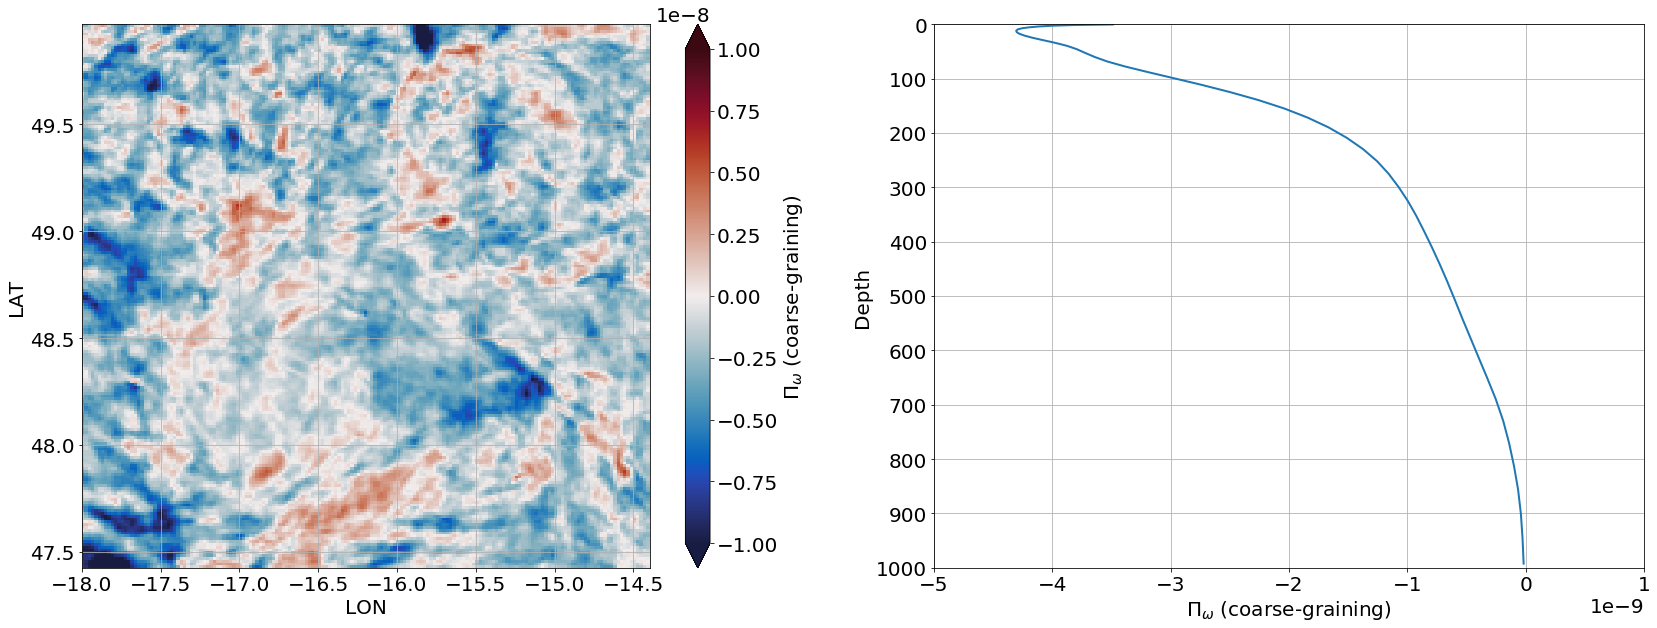

In [12]:
plt.rc('font', size=20) 

font_size=20

fig, ax = plt.subplots(figsize=(28,10))
ax = plt.subplot(121)
cax = (ds_PI.PI_cg_120h-ds_PI.PI_cg_30h).isel(lat=slice(2,-2),lon=slice(2,-2),depth=slice(10,50)).mean(['depth','time']).plot(x='lon', y='lat',cmap=cm.balance, vmin=-1e-8,vmax=1e-8, add_colorbar = False)
ax.grid()
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('$\Pi_{\omega}$ (coarse-graining)', fontsize=font_size)
ax.set_ylabel('LAT',fontsize=font_size)
ax.set_xlabel('LON',fontsize=font_size)
ax.tick_params(labelsize=font_size)

ax = plt.subplot(122)
(ds_PI.PI_cg_120h-ds_PI.PI_cg_30h).isel(lat=slice(2,-2),lon=slice(2,-2),time=slice(10,-10)).mean(['time','lat','lon']).plot(y='depth', yincrease=False, linewidth=2)
ax.grid()
ax.set_xlim([-5e-9,1e-9])
ax.set_ylim([1000., 0.])
ax.set_xticks([-5e-9, -4e-9,-3e-9, -2e-9, -1e-9, 0., 1e-9])
ax.set_ylabel('Depth',fontsize=font_size)
ax.set_xlabel('$\Pi_{\omega}$ (coarse-graining)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_yticks([1000., 900,800,700,600,500,400,300,200,100,0.])

plt.savefig('/home1/datawork/xyu/OSMOSIS_llc4320/Figures/Pi_omega_together1_coarse_graining.png')

In [13]:
out_dir = '/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/'
ds_MLD = xr.open_zarr(out_dir+'mld_filter.zarr')

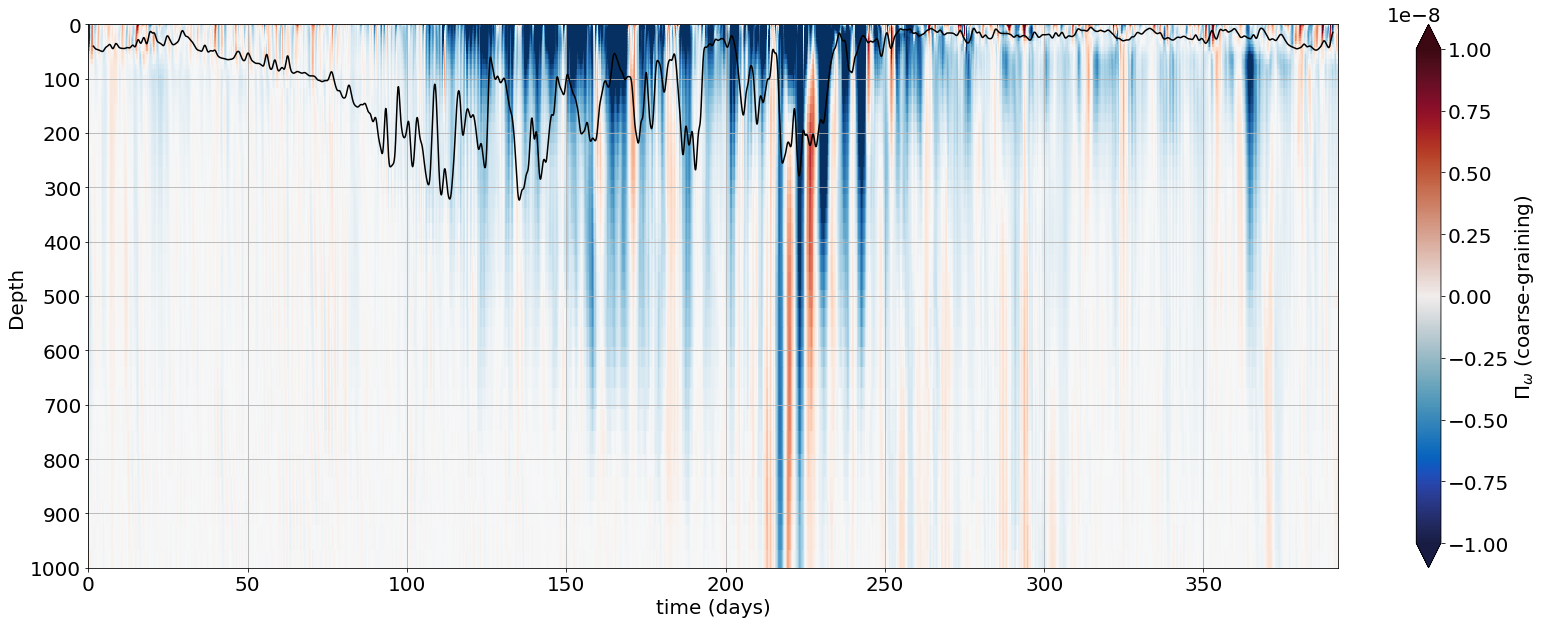

In [14]:
plt.rc('font', size=20) 
font_size=20
fig, ax = plt.subplots(figsize=(28,10))

ax = plt.subplot(111)
cax = (ds_PI.PI_cg_120h-ds_PI.PI_cg_30h).isel(lat=slice(1,-1),lon=slice(1,-1)).mean(['lon','lat']).plot(x='time', y='depth',cmap='RdBu_r', vmin=-1e-8,vmax=1e-8,yincrease=False, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('$\Pi_{\omega}$ (coarse-graining)', fontsize=font_size)
ax.grid()
ax.set_ylim([1000., 0.])
ds_MLD.mld_filter.mean(['lat','lon']).plot(x='time',yincrease=False, color='black')
ax.set_ylabel('Depth',fontsize=font_size)
ax.set_xlabel('time (days)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_yticks([1000., 900,800,700,600,500,400,300,200,100,0.])

plt.savefig('/home1/datawork/xyu/OSMOSIS_llc4320/Figures/Pi_omega_together2_coarse_graining.png')

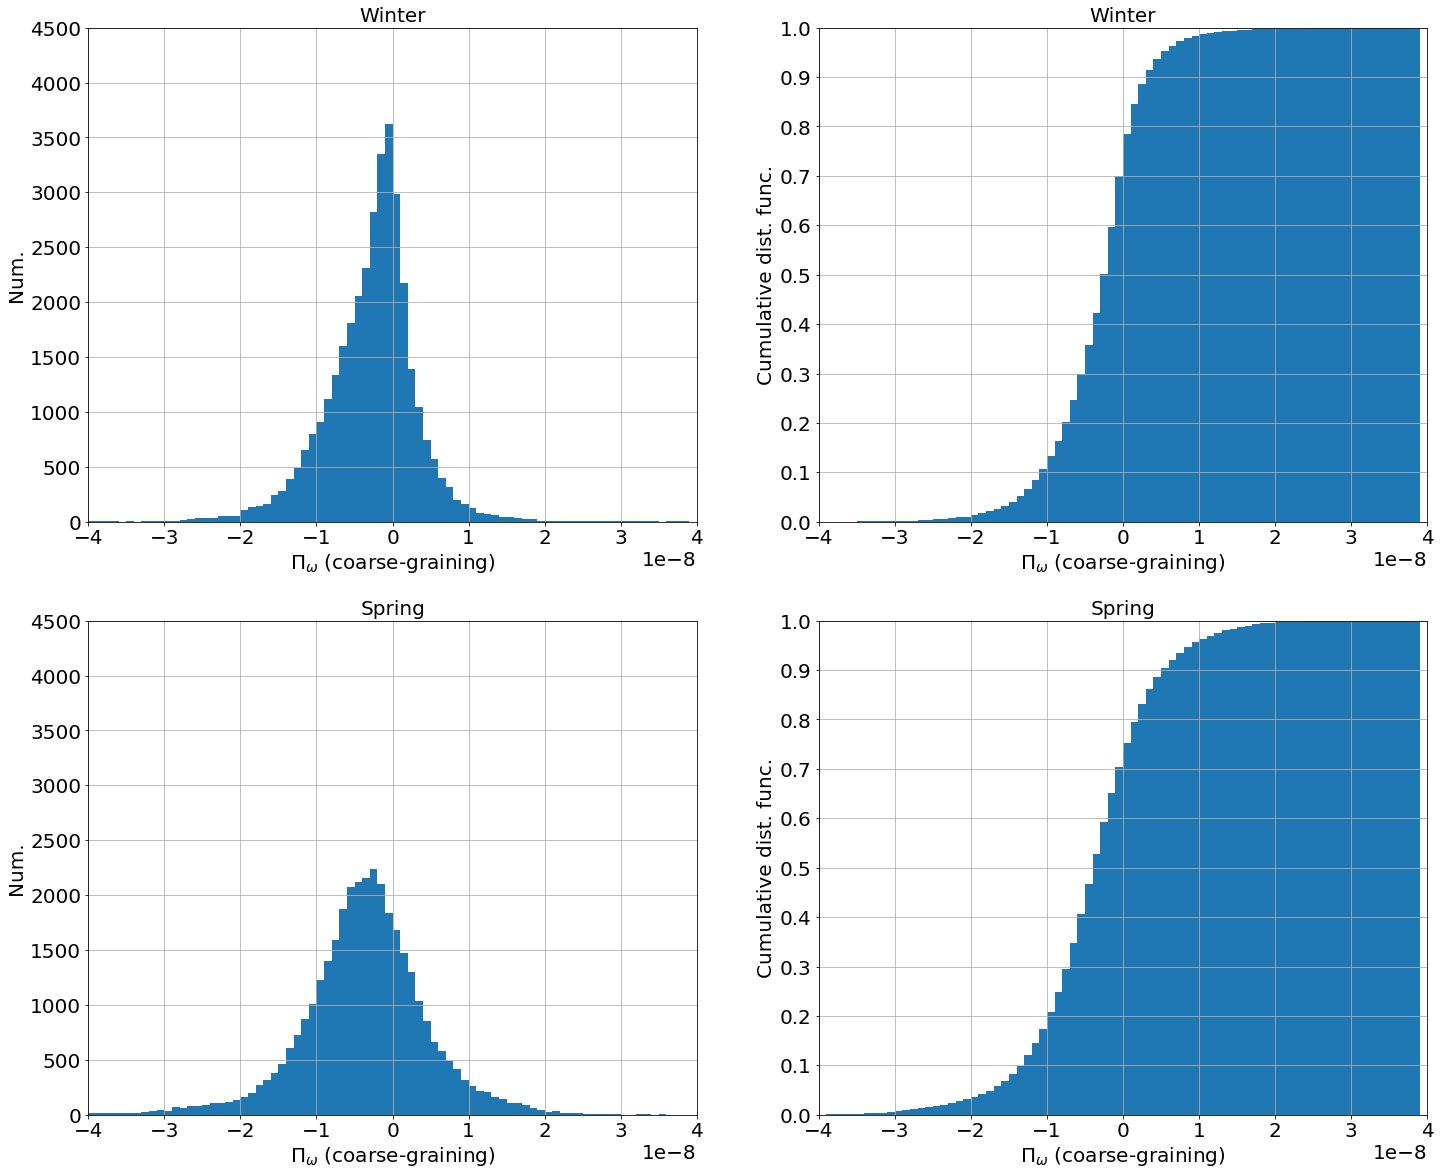

In [15]:
font_size = 20

fig, ax = plt.subplots(figsize=(24,20))

ax = plt.subplot(221)
(ds_PI.PI_cg_120h-ds_PI.PI_cg_30h).isel(time=slice(2000,4000),depth=slice(15,40)).mean(['time','depth']).plot.hist(bins=np.arange(-4e-8,4e-8,1e-9))
ax.grid()
ax.set_xlim([-4e-8,4e-8])
ax.set_ylim([0.,4500])
ax.set_ylabel('Num.',fontsize=font_size)
ax.set_xlabel('$\Pi_{\omega}$ (coarse-graining)',fontsize=font_size)
ax.set_title('Winter',fontsize=font_size)
ax.tick_params(labelsize=font_size)

ax = plt.subplot(222)
(ds_PI.PI_cg_120h-ds_PI.PI_cg_30h).isel(time=slice(2000,4000),depth=slice(15,40)).mean(['time','depth']).plot.hist(bins=np.arange(-4e-8,4e-8,1e-9),density=True,cumulative=True)
ax.grid()
ax.set_xlim([-4e-8,4e-8])
ax.set_ylim([0.,1])
ax.set_yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
ax.set_title('Winter',fontsize=font_size)
ax.set_ylabel('Cumulative dist. func.',fontsize=font_size)
ax.set_xlabel('$\Pi_{\omega}$ (coarse-graining)',fontsize=font_size)
ax.tick_params(labelsize=font_size)

ax = plt.subplot(223)
(ds_PI.PI_cg_120h-ds_PI.PI_cg_30h).isel(time=slice(4000,6000),depth=slice(15,40)).mean(['time','depth']).plot.hist(bins=np.arange(-4e-8,4e-8,1e-9))
ax.grid()
ax.set_xlim([-4e-8,4e-8])
ax.set_ylim([0.,4500])
ax.set_ylabel('Num.',fontsize=font_size)
ax.set_xlabel('$\Pi_{\omega}$ (coarse-graining)',fontsize=font_size)
ax.set_title('Spring',fontsize=font_size)
ax.tick_params(labelsize=font_size)

ax = plt.subplot(224)
(ds_PI.PI_cg_120h-ds_PI.PI_cg_30h).isel(time=slice(4000,6000),depth=slice(15,40)).mean(['time','depth']).plot.hist(bins=np.arange(-4e-8,4e-8,1e-9),density=True,cumulative=True)
ax.grid()
ax.set_xlim([-4e-8,4e-8])
ax.set_ylim([0.,1])
ax.set_yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
ax.set_ylabel('Cumulative dist. func.',fontsize=font_size)
ax.set_xlabel('$\Pi_{\omega}$ (coarse-graining)',fontsize=font_size)
ax.set_title('Spring',fontsize=font_size)
ax.tick_params(labelsize=font_size)

plt.savefig('/home1/datawork/xyu/OSMOSIS_llc4320/Figures/Pi_omega_histogram_coarse_graining.png')

_____________
# 2. Near-inertial band (0.8f - 1.2f)

In [15]:
lowcut = 1/17/3600
highcut = 1/15/3600

fs = 1/3600
nyq = 0.5*fs
low = lowcut/nyq
high = highcut/nyq

b, a = butter(4, low, 'low')
c, d = butter(4, high, 'low')
e, f = butter(4, [low, high], 'bandpass')

In [17]:
du_dx = gridx.diff(butter_filter(ds.U, b, a), 'X')/gridx.interp(ds.dxG, 'Y')
dv_dy = gridx.diff(butter_filter(ds.V, b, a), 'Y')/gridx.interp(ds.dyG, 'X')
du_dy = gridx.interp(gridx.interp(gridx.diff(butter_filter(ds.U, b, a), 'Y')/gridx.interp(ds.dyC, 'X'), 'X'), 'Y')
dv_dx = gridx.interp(gridx.interp(gridx.diff(butter_filter(ds.V, b, a), 'X')/gridx.interp(ds.dxC, 'Y'), 'X'), 'Y')

PI_1 = (gridx.interp(butter_filter(ds.U**2, b, a), 'X')-gridx.interp(butter_filter(ds.U, b, a)**2, 'X'))*du_dx
PI_2 = (gridx.interp(butter_filter(ds.V**2, b, a), 'Y')-gridx.interp(butter_filter(ds.V, b, a)**2, 'Y'))*dv_dy
PI_3 = (butter_filter(gridx.interp(ds.V,'Y')*gridx.interp(ds.U,'X'), b, a)-butter_filter(gridx.interp(ds.V,'Y'), b, a)*butter_filter(gridx.interp(ds.U,'X'), b, a) )*(du_dy+dv_dx)

PI_cg_17h = -(PI_1+PI_2+PI_3)
PI_cg_17h

<xarray.DataArray (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<neg, shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 199, 175), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36

In [9]:
du_dx = gridx.diff(butter_filter(ds.U, c, d), 'X')/gridx.interp(ds.dxG, 'Y')
dv_dy = gridx.diff(butter_filter(ds.V, c, d), 'Y')/gridx.interp(ds.dyG, 'X')
du_dy = gridx.interp(gridx.interp(gridx.diff(butter_filter(ds.U, c, d), 'Y')/gridx.interp(ds.dyC, 'X'), 'X'), 'Y')
dv_dx = gridx.interp(gridx.interp(gridx.diff(butter_filter(ds.V, c, d), 'X')/gridx.interp(ds.dxC, 'Y'), 'X'), 'Y')

PI_1 = (gridx.interp(butter_filter(ds.U**2, c, d), 'X')-gridx.interp(butter_filter(ds.U, c, d)**2, 'X'))*du_dx
PI_2 = (gridx.interp(butter_filter(ds.V**2, c, d), 'Y')-gridx.interp(butter_filter(ds.V, c, d)**2, 'Y'))*dv_dy
PI_3 = (butter_filter(gridx.interp(ds.V,'Y')*gridx.interp(ds.U,'X'), c, d) -butter_filter(gridx.interp(ds.V,'Y'), c, d)*butter_filter(gridx.interp(ds.U,'X'), c, d) )*(du_dy+dv_dx)

PI_cg_15h = -(PI_1+PI_2+PI_3)
PI_cg_15h

<xarray.DataArray (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<neg, shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 199, 175), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36

In [19]:
du_dx = gridx.diff(butter_filter(ds.U, e, f), 'X')/gridx.interp(ds.dxG, 'Y')
dv_dy = gridx.diff(butter_filter(ds.V, e, f), 'Y')/gridx.interp(ds.dyG, 'X')
du_dy = gridx.interp(gridx.interp(gridx.diff(butter_filter(ds.U, e, f), 'Y')/gridx.interp(ds.dyC, 'X'), 'X'), 'Y')
dv_dx = gridx.interp(gridx.interp(gridx.diff(butter_filter(ds.V, e, f), 'X')/gridx.interp(ds.dxC, 'Y'), 'X'), 'Y')

PI_1 = (gridx.interp(butter_filter(ds.U**2, e, f), 'X')-gridx.interp(butter_filter(ds.U, e, f)**2, 'X'))*du_dx
PI_2 = (gridx.interp(butter_filter(ds.V**2, e, f), 'Y')-gridx.interp(butter_filter(ds.V, e, f)**2, 'Y'))*dv_dy
PI_3 = (butter_filter(gridx.interp(ds.V,'Y')*gridx.interp(ds.U,'X'), e, f) -butter_filter(gridx.interp(ds.V,'Y'), e, f)*butter_filter(gridx.interp(ds.U,'X'), c, d) )*(du_dy+dv_dx)

PI_cg_15h_17h = (PI_1+PI_2+PI_3)
PI_cg_15h_17h

<xarray.DataArray (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<add, shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 199, 175), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36

In [20]:
out_dir_store = '/home1/scratch/xyu/OSMOSIS_llc4320/Pi_omega/'
depth_all = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51]

In [ ]:
# works better with few worker but a lot of memories
VV = ['PI_cg_17h']

for depth in depth_all:
    
    for vv in VV:
        
        PI_cg_17h_single = PI_cg_17h.isel(depth=depth)

        chunks = {'lat': 201, 'lon': 177, 'time':9415}            
        PI_cg_17h_single = PI_cg_17h_single.chunk(chunks)
        PI_cg_17h_single = np.real(PI_cg_17h_single).rename('PI_cg_17h_single')     
        PI_cg_17h_single = PI_cg_17h_single.to_dataset()
        file_out = out_dir_store+'/%s_d%02d.zarr'%(vv,depth)
        PI_cg_17h_single.to_zarr(file_out, mode='w')                    
        print('depth=%d - allready processed'%(depth))

depth=0 - allready processed
depth=1 - allready processed
depth=2 - allready processed
depth=3 - allready processed
depth=4 - allready processed
depth=5 - allready processed
depth=6 - allready processed
depth=7 - allready processed
depth=8 - allready processed
depth=9 - allready processed
depth=10 - allready processed
depth=11 - allready processed
depth=12 - allready processed
depth=13 - allready processed


In [11]:
# works better with few worker but a lot of memories
VV = ['PI_cg_15h']

for depth in depth_all:
    
    for vv in VV:
        
        PI_cg_15h_single = PI_cg_15h.isel(depth=depth)

        chunks = {'lat': 201, 'lon': 177, 'time':9415}            
        PI_cg_15h_single = PI_cg_15h_single.chunk(chunks)
        PI_cg_15h_single = np.real(PI_cg_15h_single).rename('PI_cg_15h_single')     
        PI_cg_15h_single = PI_cg_15h_single.to_dataset()
        file_out = out_dir_store+'/%s_d%02d.zarr'%(vv,depth)
        PI_cg_15h_single.to_zarr(file_out, mode='w')                    
        print('depth=%d - allready processed'%(depth))

depth=0 - allready processed
depth=1 - allready processed
depth=2 - allready processed
depth=3 - allready processed
depth=4 - allready processed
depth=5 - allready processed
depth=6 - allready processed
depth=7 - allready processed
depth=8 - allready processed
depth=9 - allready processed
depth=10 - allready processed
depth=11 - allready processed
depth=12 - allready processed
depth=13 - allready processed
depth=14 - allready processed
depth=15 - allready processed
depth=16 - allready processed
depth=17 - allready processed
depth=18 - allready processed
depth=19 - allready processed
depth=20 - allready processed
depth=21 - allready processed
depth=22 - allready processed
depth=23 - allready processed
depth=24 - allready processed
depth=25 - allready processed
depth=26 - allready processed
depth=27 - allready processed
depth=28 - allready processed
depth=29 - allready processed
depth=30 - allready processed
depth=31 - allready processed
depth=32 - allready processed
depth=33 - allready 

In [21]:
# works better with few worker but a lot of memories
VV = ['PI_cg_15h_17h']

for depth in depth_all:
    
    for vv in VV:
        
        PI_cg_15h_17h_single = PI_cg_15h_17h.isel(depth=depth)

        chunks = {'lat': 201, 'lon': 177, 'time':9415}            
        PI_cg_15h_17h_single = PI_cg_15h_17h_single.chunk(chunks)
        PI_cg_15h_17h_single = np.real(PI_cg_15h_17h_single).rename('PI_cg_15h_17h_single')     
        PI_cg_15h_17h_single = PI_cg_15h_17h_single.to_dataset()
        file_out = out_dir_store+'/%s_d%02d.zarr'%(vv,depth)
        PI_cg_15h_17h_single.to_zarr(file_out, mode='w')                    
        print('depth=%d - allready processed'%(depth))

depth=0 - allready processed
depth=1 - allready processed
depth=2 - allready processed
depth=3 - allready processed
depth=4 - allready processed
depth=5 - allready processed
depth=6 - allready processed
depth=7 - allready processed
depth=8 - allready processed
depth=9 - allready processed
depth=10 - allready processed
depth=11 - allready processed
depth=12 - allready processed
depth=13 - allready processed
depth=14 - allready processed
depth=15 - allready processed
depth=16 - allready processed
depth=17 - allready processed
depth=18 - allready processed
depth=19 - allready processed
depth=20 - allready processed
depth=21 - allready processed
depth=22 - allready processed
depth=23 - allready processed
depth=24 - allready processed
depth=25 - allready processed
depth=26 - allready processed
depth=27 - allready processed
depth=28 - allready processed
depth=29 - allready processed
depth=30 - allready processed
depth=31 - allready processed
depth=32 - allready processed
depth=33 - allready 

## Read data

In [9]:
out_dir_store = '/home1/scratch/xyu/OSMOSIS_llc4320/Pi_omega/'
D = [xr.open_zarr(out_dir_store+'PI_cg_17h_d%02d.zarr'%(depth)) for depth in range(52)]

PI_cg_17h = xr.concat(D, dim='depth')
PI_cg_17h = PI_cg_17h.PI_cg_17h_single
PI_cg_17h

<xarray.DataArray 'PI_cg_17h_single' (depth: 52, time: 9415, lat: 201, lon: 177)>
dask.array<concatenate, shape=(52, 9415, 201, 177), dtype=float32, chunksize=(1, 9415, 201, 177), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3

In [10]:
out_dir_store = '/home1/scratch/xyu/OSMOSIS_llc4320/Pi_omega/'
D = [xr.open_zarr(out_dir_store+'PI_cg_15h_d%02d.zarr'%(depth)) for depth in range(52)]

PI_cg_15h = xr.concat(D, dim='depth')
PI_cg_15h = PI_cg_15h.PI_cg_15h_single
PI_cg_15h

<xarray.DataArray 'PI_cg_15h_single' (depth: 52, time: 9415, lat: 201, lon: 177)>
dask.array<concatenate, shape=(52, 9415, 201, 177), dtype=float32, chunksize=(1, 9415, 201, 177), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3

In [11]:
out_dir_store = '/home1/scratch/xyu/OSMOSIS_llc4320/Pi_omega/'
D = [xr.open_zarr(out_dir_store+'PI_cg_15h_17h_d%02d.zarr'%(depth)) for depth in range(52)]

PI_cg_15h_17h = xr.concat(D, dim='depth')
PI_cg_15h_17h = PI_cg_15h_17h.PI_cg_15h_17h_single
PI_cg_15h_17h

<xarray.DataArray 'PI_cg_15h_17h_single' (depth: 52, time: 9415, lat: 201, lon: 177)>
dask.array<concatenate, shape=(52, 9415, 201, 177), dtype=float32, chunksize=(1, 9415, 201, 177), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3

In [14]:
out_dir_work = '/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/'

grid = xr.open_dataset(out_dir_work+'Grid.nc', decode_coords=True)
#ds_PI = xr.merge([PI_cg_17h,PI_cg_15h,PI_cg_15h_17h,grid])
ds_PI = xr.merge([PI_cg_17h,PI_cg_15h,PI_cg_15h_17h,PI_cg_120h,grid])
ds_PI

<xarray.Dataset>
Dimensions:               (depth: 52, lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 9415)
Coordinates:
  * time                  (time) float64 0.0 0.04167 0.08333 ... 392.2 392.2
  * lat                   (lat) float64 47.4 47.42 47.43 ... 49.96 49.98 49.99
  * lon                   (lon) float64 -18.03 -18.01 -17.99 ... -14.39 -14.36
  * depth                 (depth) float64 0.5 1.57 2.79 ... 900.1 945.6 992.3
    XC                    (lat, lon) float32 ...
    YC                    (lat, lon) float32 ...
    XG                    (lat_g, lon_g) float32 ...
    YG                    (lat_g, lon_g) float32 ...
    CS                    (lat, lon) float32 ...
    SN                    (lat, lon) float32 ...
    Depth                 (lat, lon) float32 ...
    dxC                   (lat, lon_g) float32 ...
    dyC                   (lat_g, lon) float32 ...
    dxG                   (lat_g, lon) float32 ...
    dyG                   (lat, lon_g) float32 ...
    rA  

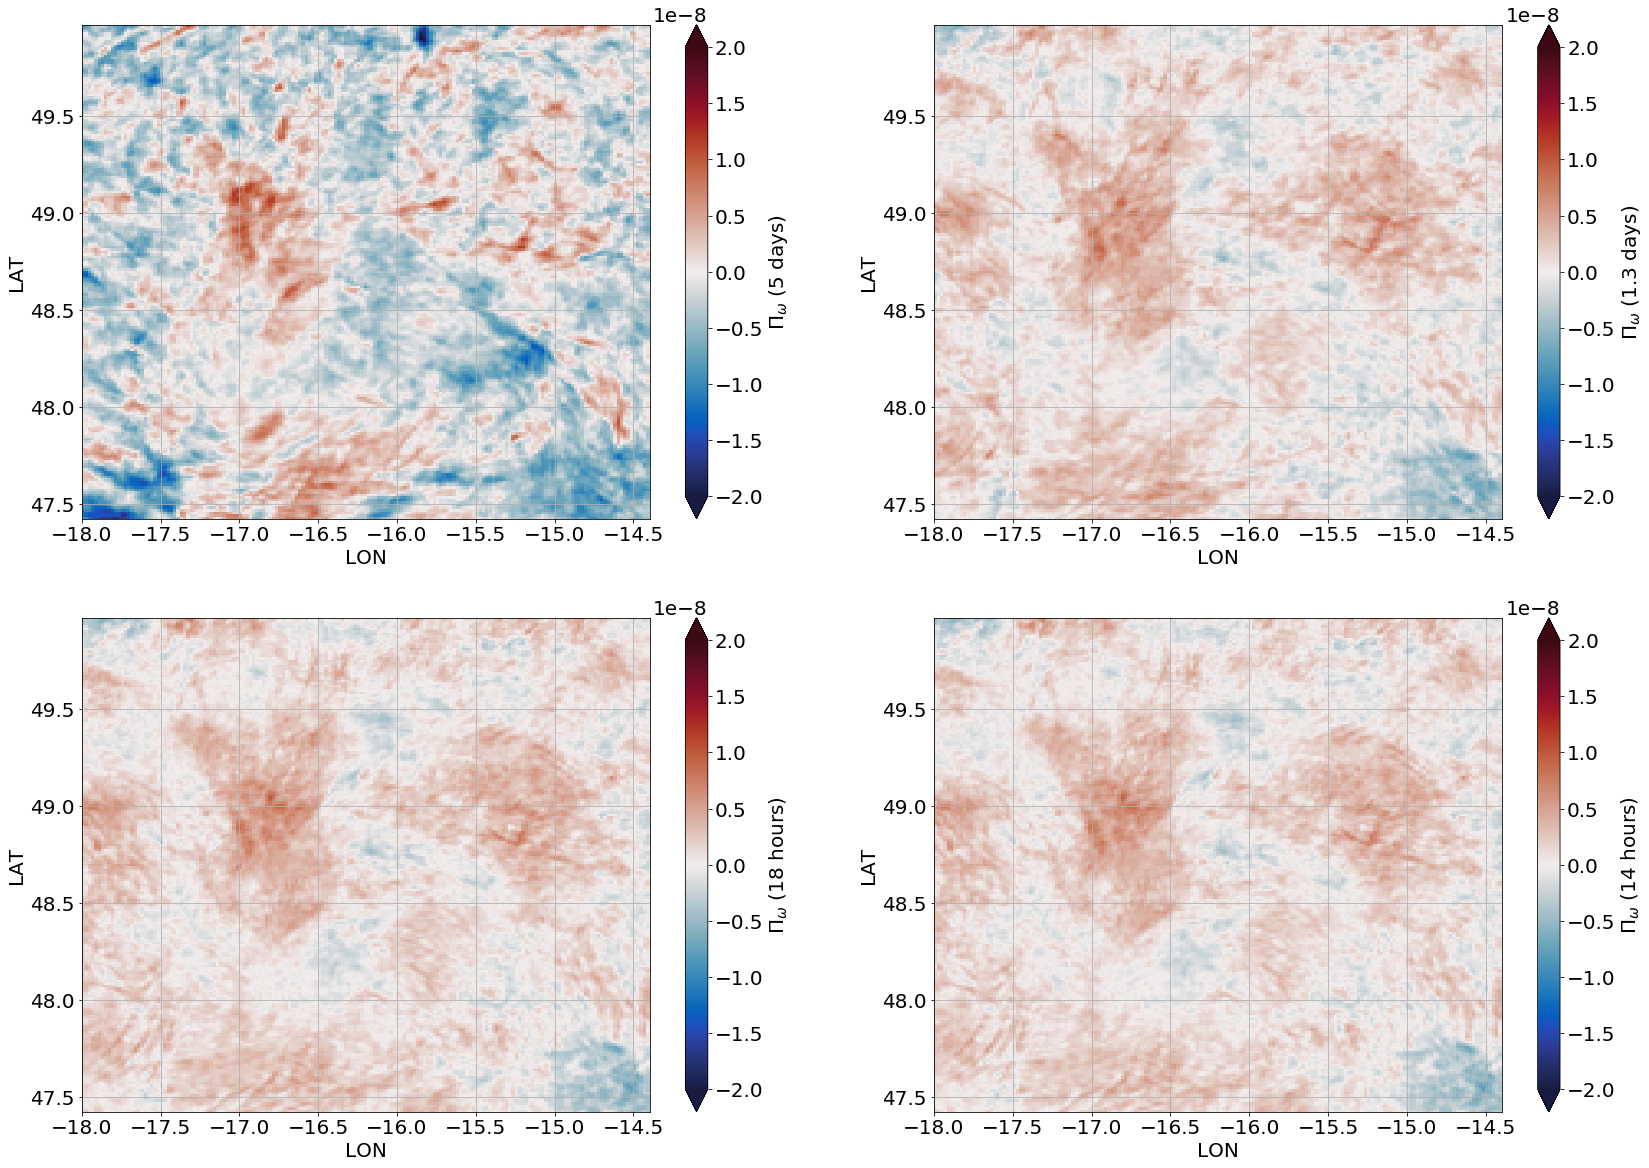

In [24]:
plt.rc('font', size=20) 
font_size=20

fig, ax = plt.subplots(figsize=(28,20))

ax = plt.subplot(221)
cax = (PI_cg_120h).isel(lat=slice(2,-2),lon=slice(2,-2)).mean(['depth','time']).plot(x='lon', y='lat',cmap=cm.balance, vmin=-2e-8,vmax=2e-8, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('$\Pi_{\omega}$ (5 days)', fontsize=font_size)
ax.set_ylabel('LAT',fontsize=font_size)
ax.set_xlabel('LON',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.grid()

ax = plt.subplot(222)
cax = (PI_cg_30h).isel(lat=slice(2,-2),lon=slice(2,-2)).mean(['depth','time']).plot(x='lon', y='lat',cmap=cm.balance, vmin=-2e-8,vmax=2e-8, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('$\Pi_{\omega}$ (1.3 days)', fontsize=font_size)
ax.set_ylabel('LAT',fontsize=font_size)
ax.set_xlabel('LON',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.grid()

ax = plt.subplot(223)
cax = (ds_PI.PI_cg_17h_single).isel(lat=slice(2,-2),lon=slice(2,-2)).mean(['depth','time']).plot(x='lon', y='lat',cmap=cm.balance, vmin=-2e-8,vmax=2e-8, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('$\Pi_{\omega}$ (18 hours)', fontsize=font_size)
ax.set_ylabel('LAT',fontsize=font_size)
ax.set_xlabel('LON',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.grid()

ax = plt.subplot(224)
cax = (ds_PI.PI_cg_15h_single).isel(lat=slice(2,-2),lon=slice(2,-2)).mean(['depth','time']).plot(x='lon', y='lat',cmap=cm.balance, vmin=-2e-8,vmax=2e-8, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('$\Pi_{\omega}$ (14 hours)', fontsize=font_size)
ax.set_ylabel('LAT',fontsize=font_size)
ax.set_xlabel('LON',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.grid()

plt.savefig('/home1/datawork/xyu/OSMOSIS_llc4320/Figures/Pi_omega_coarse_graining_NI1.png')

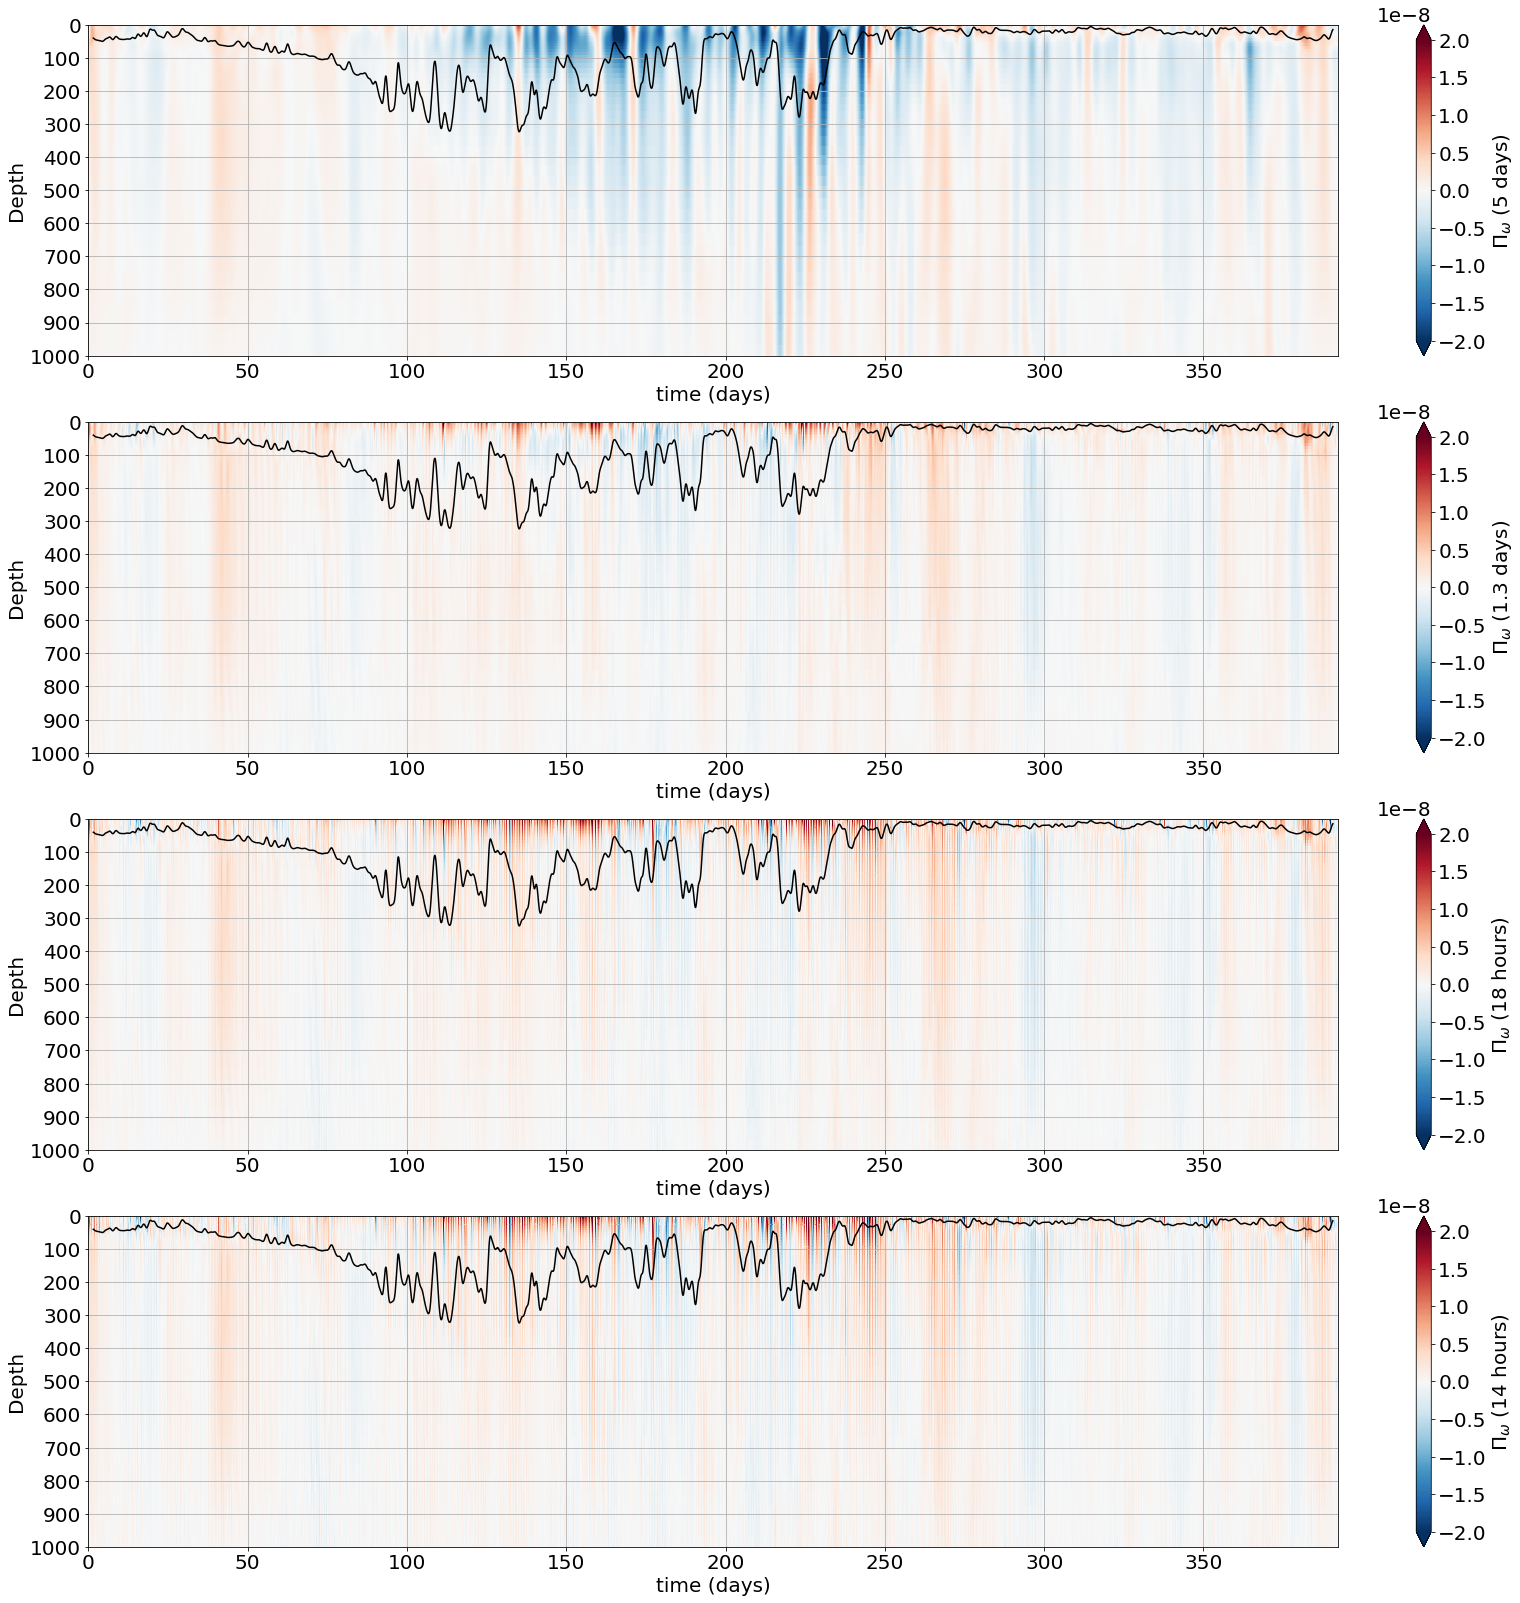

In [21]:
out_dir = '/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/'
ds_MLD = xr.open_zarr(out_dir+'mld_filter.zarr')

plt.rc('font', size=20) 
font_size=20
fig, ax = plt.subplots(figsize=(28,28))

ax = plt.subplot(411)
cax = (PI_cg_120h).isel(lat=slice(1,-1),lon=slice(1,-1)).mean(['lon','lat']).plot(x='time', y='depth',cmap='RdBu_r', vmin=-2e-8,vmax=2e-8,yincrease=False, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('$\Pi_{\omega}$ (5 days)', fontsize=font_size)
ax.grid()
ax.set_ylim([1000., 0.])
ax.set_yticks([0,100,200,300,400,500,600,700,800,900,1000])

ds_MLD.mld_filter.mean(['lat','lon']).plot(x='time',yincrease=False, color='black')
ax.set_ylabel('Depth',fontsize=font_size)
ax.set_xlabel('time (days)',fontsize=font_size)
ax.tick_params(labelsize=font_size)

ax = plt.subplot(412)
cax = (PI_cg_30h).isel(lat=slice(1,-1),lon=slice(1,-1)).mean(['lon','lat']).plot(x='time', y='depth',cmap='RdBu_r', vmin=-2e-8,vmax=2e-8,yincrease=False, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('$\Pi_{\omega}$ (1.3 days)', fontsize=font_size)
ax.grid()
ax.set_ylim([1000., 0.])
ax.set_yticks([0,100,200,300,400,500,600,700,800,900,1000])
ds_MLD.mld_filter.mean(['lat','lon']).plot(x='time',yincrease=False, color='black')
ax.set_ylabel('Depth',fontsize=font_size)
ax.set_xlabel('time (days)',fontsize=font_size)
ax.tick_params(labelsize=font_size)

ax = plt.subplot(413)
cax = (ds_PI.PI_cg_17h_single).isel(lat=slice(1,-1),lon=slice(1,-1)).mean(['lon','lat']).plot(x='time', y='depth',cmap='RdBu_r', vmin=-2e-8,vmax=2e-8,yincrease=False, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('$\Pi_{\omega}$ (18 hours)', fontsize=font_size)
ax.grid()
ax.set_ylim([1000., 0.])
ax.set_yticks([0,100,200,300,400,500,600,700,800,900,1000])
ds_MLD.mld_filter.mean(['lat','lon']).plot(x='time',yincrease=False, color='black')
ax.set_ylabel('Depth',fontsize=font_size)
ax.set_xlabel('time (days)',fontsize=font_size)
ax.tick_params(labelsize=font_size)

ax = plt.subplot(414)
cax = (ds_PI.PI_cg_15h_single).isel(lat=slice(1,-1),lon=slice(1,-1)).mean(['lon','lat']).plot(x='time', y='depth',cmap='RdBu_r', vmin=-2e-8,vmax=2e-8,yincrease=False, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('$\Pi_{\omega}$ (14 hours)', fontsize=font_size)
ax.grid()
ax.set_ylim([1000., 0.])
ax.set_yticks([0,100,200,300,400,500,600,700,800,900,1000])
ds_MLD.mld_filter.mean(['lat','lon']).plot(x='time',yincrease=False, color='black')
ax.set_ylabel('Depth',fontsize=font_size)
ax.set_xlabel('time (days)',fontsize=font_size)
ax.tick_params(labelsize=font_size)

plt.savefig('/home1/datawork/xyu/OSMOSIS_llc4320/Figures/Pi_omega_coarse_graining_NI2.png')

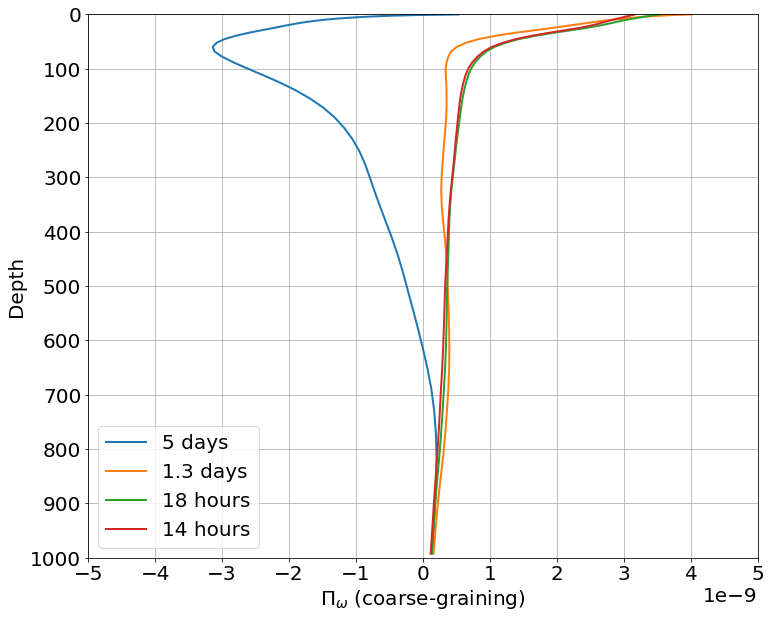

In [23]:
plt.rc('font', size=20) 

font_size=20

fig, ax = plt.subplots(figsize=(12,10))

labels = ['5 days','1.3 days','18 hours', '14 hours']
ax = plt.subplot(111)
(PI_cg_120h).isel(lat=slice(2,-2),lon=slice(2,-2),time=slice(10,-10)).mean(['time','lat','lon']).plot(y='depth', yincrease=False, label=labels[0], linewidth=2)
(PI_cg_30h).isel(lat=slice(2,-2),lon=slice(2,-2),time=slice(10,-10)).mean(['time','lat','lon']).plot(y='depth', yincrease=False, label=labels[1], linewidth=2)
(ds_PI.PI_cg_17h_single).isel(lat=slice(2,-2),lon=slice(2,-2),time=slice(10,-10)).mean(['time','lat','lon']).plot(y='depth', yincrease=False, label=labels[2], linewidth=2)
(ds_PI.PI_cg_15h_single).isel(lat=slice(2,-2),lon=slice(2,-2),time=slice(10,-10)).mean(['time','lat','lon']).plot(y='depth', yincrease=False, label=labels[3], linewidth=2)
ax.grid()
ax.legend();
ax.set_xlim([-5e-9,5e-9])
ax.set_ylim([1000., 0.])
ax.set_xticks([-5e-9,-4e-9,-3e-9,-2e-9,-1e-9, 0., 1e-9, 2e-9, 3e-9, 4e-9, 5e-9])
ax.set_yticks([0,100,200,300,400,500,600,700,800,900,1000])
ax.set_ylabel('Depth',fontsize=font_size)
ax.set_xlabel('$\Pi_{\omega}$ (coarse-graining)',fontsize=font_size)
ax.tick_params(labelsize=font_size)

plt.savefig('/home1/datawork/xyu/OSMOSIS_llc4320/Figures/Pi_omega_coarse_graining_NI3.png')

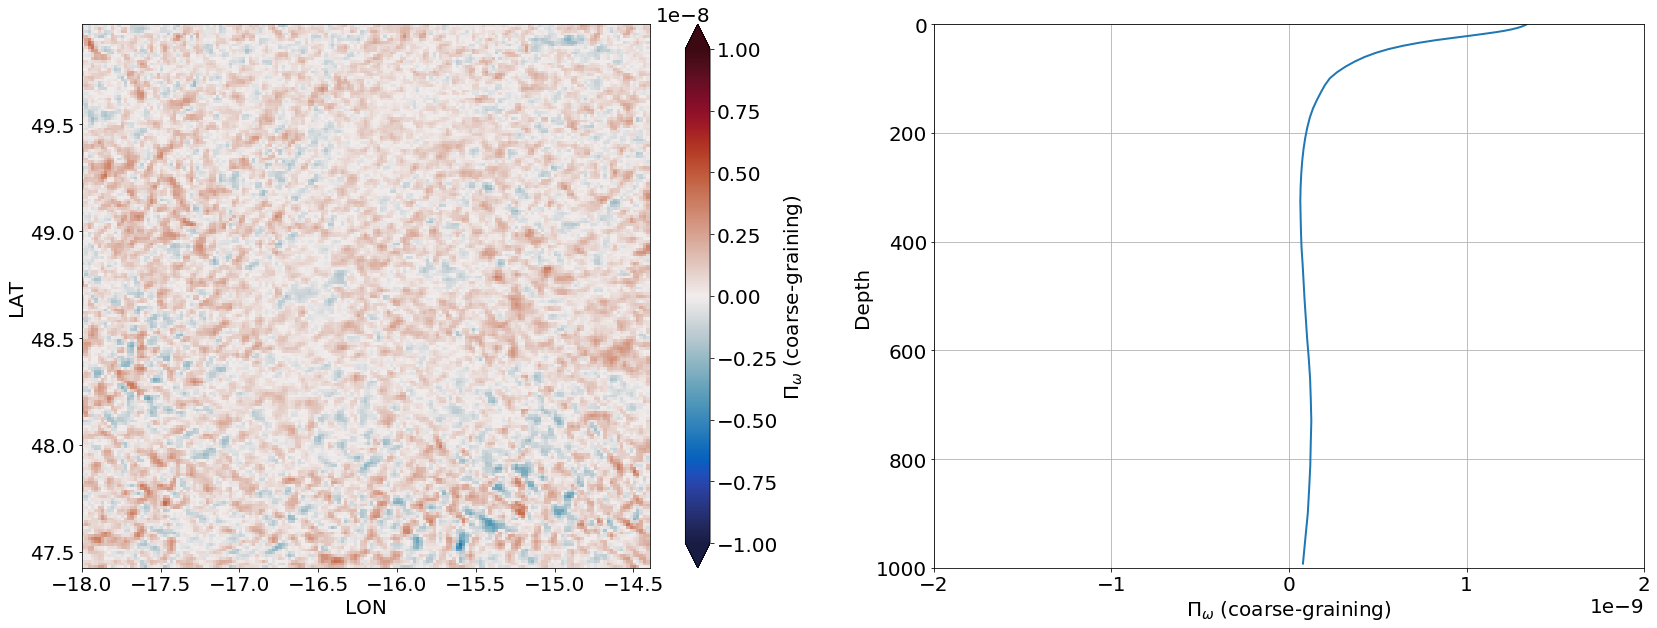

In [28]:
plt.rc('font', size=20) 

font_size=20

fig, ax = plt.subplots(figsize=(28,10))
ax = plt.subplot(121)
cax = (ds_PI.PI_cg_15h_17h_single).isel(lat=slice(2,-2),lon=slice(2,-2)).mean(['depth','time']).plot(x='lon', y='lat',cmap=cm.balance, vmin=-1e-8,vmax=1e-8, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('$\Pi_{\omega}$ (coarse-graining)', fontsize=font_size)
ax.set_ylabel('LAT',fontsize=font_size)
ax.set_xlabel('LON',fontsize=font_size)
ax.tick_params(labelsize=font_size)

ax = plt.subplot(122)
(ds_PI.PI_cg_15h_17h_single).isel(lat=slice(2,-2),lon=slice(2,-2),time=slice(10,-10)).mean(['time','lat','lon']).plot(y='depth', yincrease=False, linewidth=2)
ax.grid()
ax.set_xlim([-2e-9,2e-9])
ax.set_ylim([1000., 0.])
ax.set_xticks([-2e-9,-1e-9, 0., 1e-9, 2e-9])
ax.set_ylabel('Depth',fontsize=font_size)
ax.set_xlabel('$\Pi_{\omega}$ (coarse-graining)',fontsize=font_size)
ax.tick_params(labelsize=font_size)

#plt.savefig('/home1/datawork/xyu/OSMOSIS_llc4320/Figures/Pi_omega_together1_coarse_graining.png')

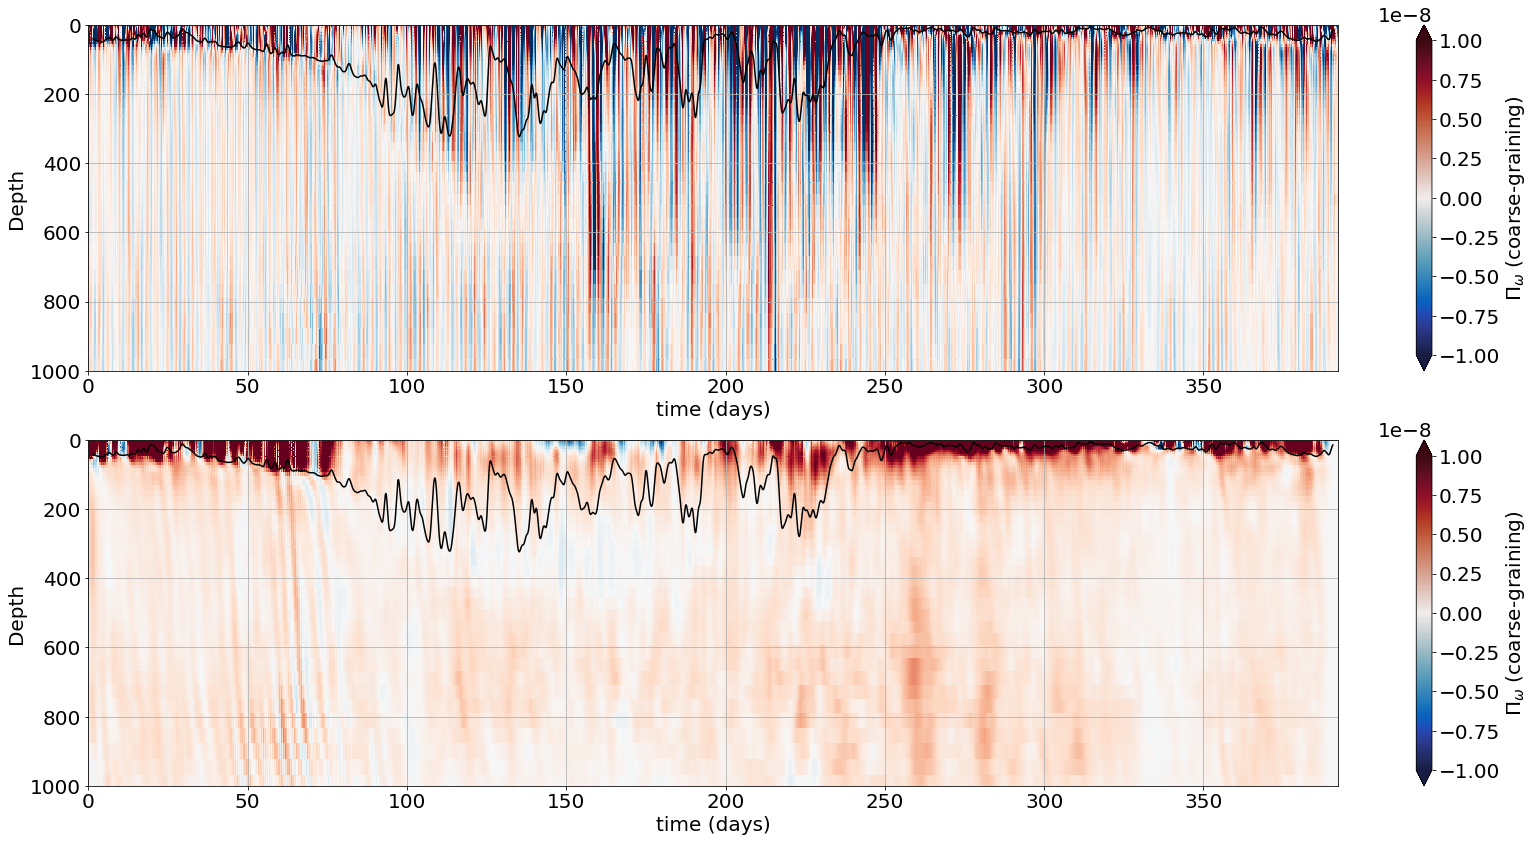

In [31]:
out_dir = '/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/'
ds_MLD = xr.open_zarr(out_dir+'mld_filter.zarr')

plt.rc('font', size=20) 
font_size=20
fig, ax = plt.subplots(figsize=(28,14))

ax = plt.subplot(211)
cbar = (ds_PI.PI_cg_17h_single-ds_PI.PI_cg_15h_single).isel(lat=slice(1,-1),lon=slice(1,-1)).mean(['lon','lat']).plot(x='time', y='depth',cmap='RdBu_r', vmin=-1e-9,vmax=1e-9,yincrease=False, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('$\Pi_{\omega}$ (coarse-graining)', fontsize=font_size)
ax.grid()
ax.set_ylim([1000., 0.])
ds_MLD.mld_filter.mean(['lat','lon']).plot(x='time',yincrease=False, color='black')
ax.set_ylabel('Depth',fontsize=font_size)
ax.set_xlabel('time (days)',fontsize=font_size)
ax.tick_params(labelsize=font_size)

ax = plt.subplot(212)
cbar = (ds_PI.PI_cg_15h_17h_single).isel(lat=slice(1,-1),lon=slice(1,-1)).mean(['lon','lat']).plot(x='time', y='depth',cmap='RdBu_r', vmin=-1e-9,vmax=1e-9,yincrease=False, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('$\Pi_{\omega}$ (coarse-graining)', fontsize=font_size)
ax.grid()
ax.set_ylim([1000., 0.])
ds_MLD.mld_filter.mean(['lat','lon']).plot(x='time',yincrease=False, color='black')
ax.set_ylabel('Depth',fontsize=font_size)
ax.set_xlabel('time (days)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
#plt.savefig('/home1/datawork/xyu/OSMOSIS_llc4320/Figures/Pi_omega_together2_coarse_graining.png')

In [25]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1276, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1005, in _reconnect
    await self._close()
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1